<a href="https://colab.research.google.com/github/Mevaria/AAI614_Wehbe/blob/main/Outlier_Detection_With_IQR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vanessa Wehbe

# 📌 Outlier Detection with IQR — Insurance Dataset

In this notebook, I used the **IQR method** to find and interpret outliers in the medical insurance dataset found at kaggle (https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset?resource=download).

### Load Data & Overview

Preview the dataset and basic stats to understand its structure.

In [24]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("insurance.csv")

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [26]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Helper Functions





In [27]:
def iqr_bounds(series: pd.Series, k: float = 1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return q1, q3, lower, upper


def flag_outliers_iqr(df: pd.DataFrame, cols=None, k: float = 1.5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    flags = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        s = df[c].dropna()
        _, _, lower, upper = iqr_bounds(s, k=k)
        flags.loc[s.index, c] = (df.loc[s.index, c] < lower) | (df.loc[s.index, c] > upper)
    return flags


def iqr_bounds(series: pd.Series, k: float = 1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return q1, q3, lower, upper


def groupwise_iqr_flags(df: pd.DataFrame, feature: str, by: str):
    rows = []
    out = {}
    for grp, sub in df.groupby(by):
        s = sub[feature].dropna()
        if s.empty:
            continue
        q1, q3, lower15, upper15 = iqr_bounds(s, 1.5)
        _,  _, lower30, upper30 = iqr_bounds(s, 3.0)

        mild_mask    = (sub[feature] < lower15) | (sub[feature] > upper15)
        extreme_mask = (sub[feature] < lower30) | (sub[feature] > upper30)

        rows.append({
            by: grp,
            "n": len(sub),
            "q1": q1, "q3": q3,
            "lower_1p5": lower15, "upper_1p5": upper15,
            "lower_3p0": lower30, "upper_3p0": upper30,
            "mild_count": int(mild_mask.sum()),
            "extreme_count": int(extreme_mask.sum()),
            "mild_pct": float(mild_mask.mean()*100),
            "extreme_pct": float(extreme_mask.mean()*100),
        })

    summary = pd.DataFrame(rows).sort_values("mild_count", ascending=False).reset_index(drop=True)
    return summary


def hist_per_group_with_bounds(df: pd.DataFrame, feature: str, by: str, bins: int = 20):
    for grp, sub in df.groupby(by):
        s = sub[feature].dropna()
        if s.empty:
            continue
        q1, q3, lower15, upper15 = iqr_bounds(s, 1.5)
        _,  _, lower30, upper30 = iqr_bounds(s, 3.0)

        plt.figure(figsize=(8,5))
        plt.hist(s, bins=bins)
        plt.axvline(lower15, linestyle="--", label="Lower (1.5×IQR)")
        plt.axvline(upper15, linestyle="--", label="Upper (1.5×IQR)")
        plt.axvline(lower30, linestyle="--", label="Lower (3×IQR)")
        plt.axvline(upper30, linestyle="--", label="Upper (3×IQR)")
        plt.title(f"{feature} by {by} = {grp}")
        plt.xlabel(feature)
        plt.ylabel("count")
        plt.legend()
        plt.show()


def category_boxplot(df: pd.DataFrame, feature: str, by: str):
    data = [grp[feature].dropna().values for _, grp in df.groupby(by)]
    labels = [str(name) for name, _ in df.groupby(by)]
    plt.figure(figsize=(8,5))
    plt.boxplot(data, tick_labels=labels, vert=True)
    plt.title(f"{feature} by {by}")
    plt.ylabel(feature)
    plt.show()


def add_regression(ax, x, y, label):
    m, b = np.polyfit(x, y, deg=1)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, m*xs + b, linestyle="-", linewidth=2, label=f"{label} trend")


def binned_stats(x, y, bins=8):
    cuts = pd.cut(x, bins=bins)
    g = y.groupby(cuts)
    return g.median(), g.quantile(0.25), g.quantile(0.75), cuts.cat.categories

## Quick Overview of Outliers

In [28]:
# Detect outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
flags_15 = flag_outliers_iqr(df, cols=numeric_cols, k=1.5)
flags_30 = flag_outliers_iqr(df, cols=numeric_cols, k=3.0)

summary = pd.DataFrame({
    "feature": numeric_cols,
    "outliers_k1.5": [flags_15[c].sum() for c in numeric_cols],
    "outliers_k3.0": [flags_30[c].sum() for c in numeric_cols],
}).sort_values("outliers_k1.5", ascending=False).reset_index(drop=True)

print("Outlier Summary")
display(summary)

Outlier Summary


,feature,outliers_k1.5,outliers_k3.0
0,charges,139,6
1,bmi,9,0
2,age,0,0
3,children,0,0


In [29]:
# Show some flagged rows
outlier_rows = df.loc[flags_15.any(axis=1)].copy()
outlier_rows["trigger_features"] = [
    ", ".join([c for c in numeric_cols if flags_15.loc[idx, c]])
    for idx in outlier_rows.index
]
display(outlier_rows.head(10))  # show first 10

,age,sex,bmi,children,smoker,region,charges,trigger_features
14,27,male,42.13,0,yes,southeast,39611.75770,charges
19,30,male,35.30,0,yes,southwest,36837.46700,charges
23,34,female,31.92,1,yes,northeast,37701.87680,charges
29,31,male,36.30,2,yes,southwest,38711.00000,charges
30,22,male,35.60,0,yes,southwest,35585.57600,charges
34,28,male,36.40,1,yes,southwest,51194.55914,charges
38,35,male,36.67,1,yes,northeast,39774.27630,charges
39,60,male,39.90,0,yes,southwest,48173.36100,charges
49,36,male,35.20,1,yes,southeast,38709.17600,charges
53,36,male,34.43,0,yes,southeast,37742.57570,charges


## Visualizations

### 1. Boxplots

Boxplots show the spread of each numeric feature and highlight potential outliers.

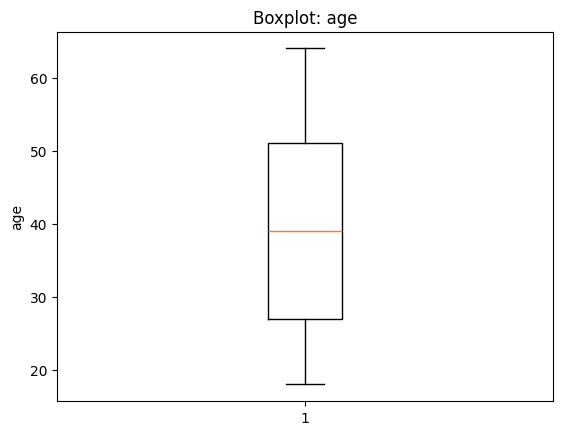

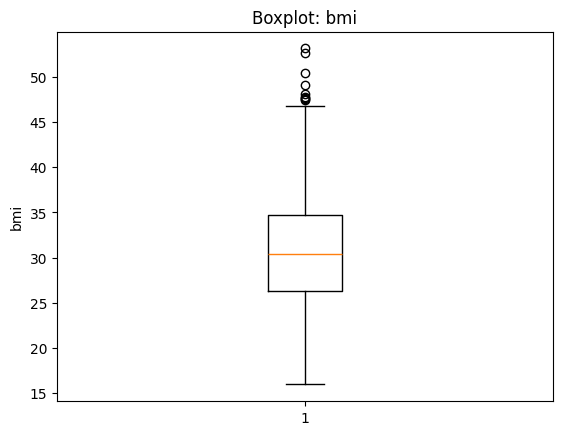

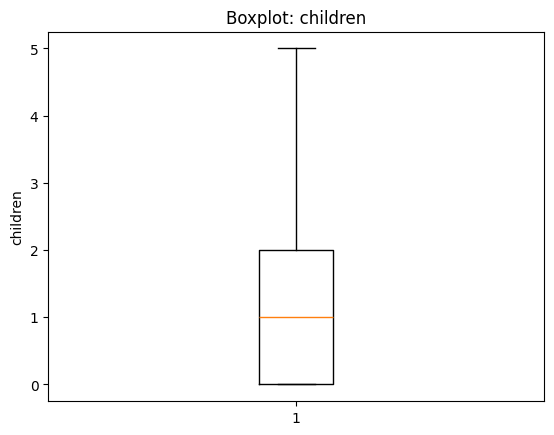

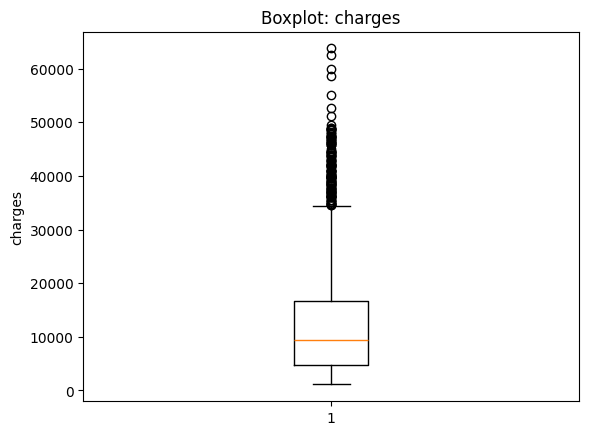

In [30]:
# Boxplots (quick distribution check)
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.show()

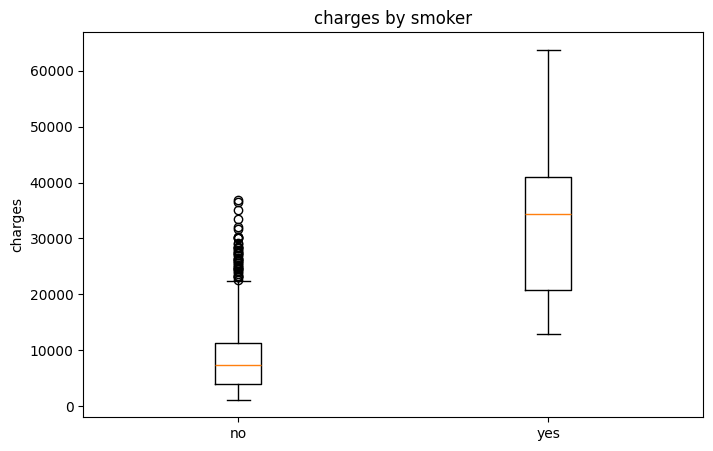

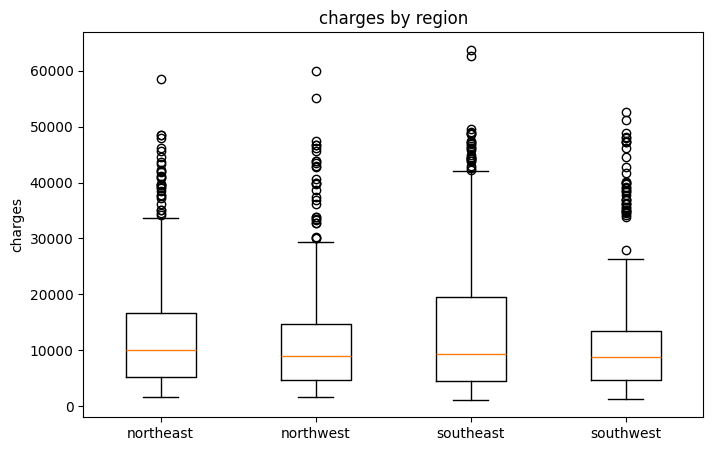

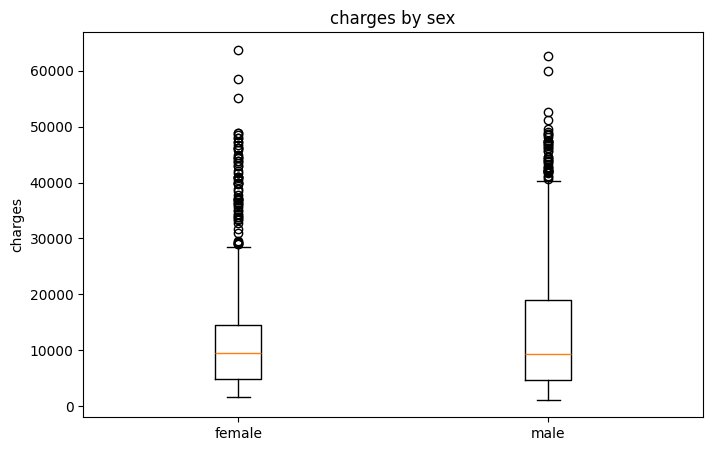

In [31]:
category_boxplot(df, feature="charges", by="smoker")
category_boxplot(df, feature="charges", by="region")
category_boxplot(df, feature="charges", by="sex")

### 2. Histograms with IQR Cutoffs

Histograms with 1.5x and 3x IQR cutoffs show mild vs extreme outliers.

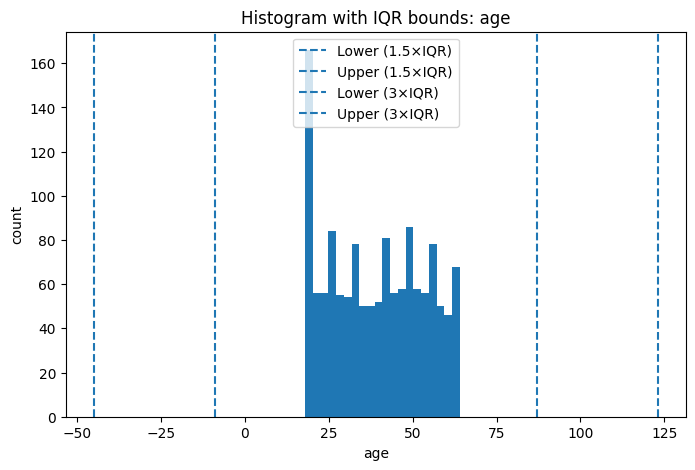

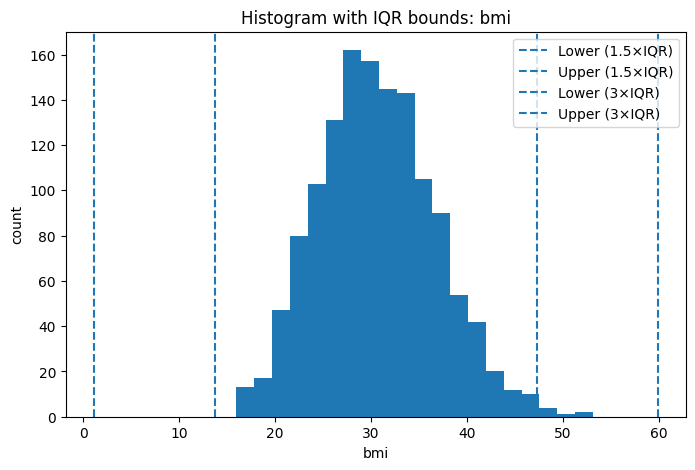

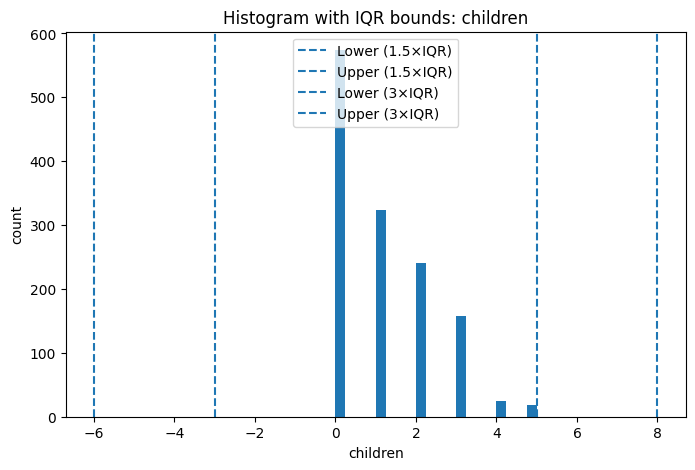

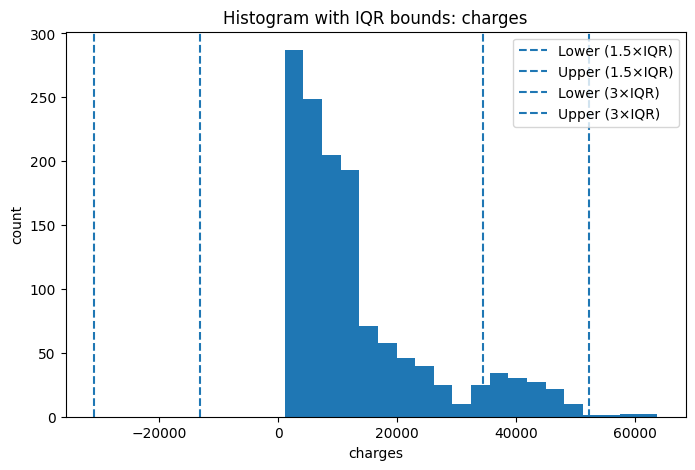

In [32]:
# Histograms per numeric feature with BOTH cutoffs (1.5×IQR and 3×IQR)
for col in numeric_cols:
    data = df[col].dropna()
    q1, q3, lower15, upper15 = iqr_bounds(data, k=1.5)
    _,  _, lower30, upper30 = iqr_bounds(data, k=3.0)

    plt.figure(figsize=(8,5))
    plt.hist(data, bins=20)

    # Mild (1.5×IQR) bounds
    plt.axvline(lower15, linestyle="--", label="Lower (1.5×IQR)")
    plt.axvline(upper15, linestyle="--", label="Upper (1.5×IQR)")

    # Extreme (3×IQR) bounds
    plt.axvline(lower30, linestyle="--", label="Lower (3×IQR)")
    plt.axvline(upper30, linestyle="--", label="Upper (3×IQR)")

    plt.title(f"Histogram with IQR bounds: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()
    plt.show()

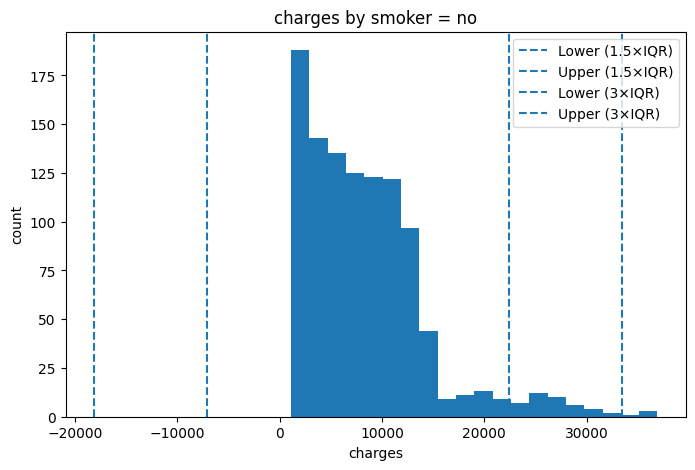

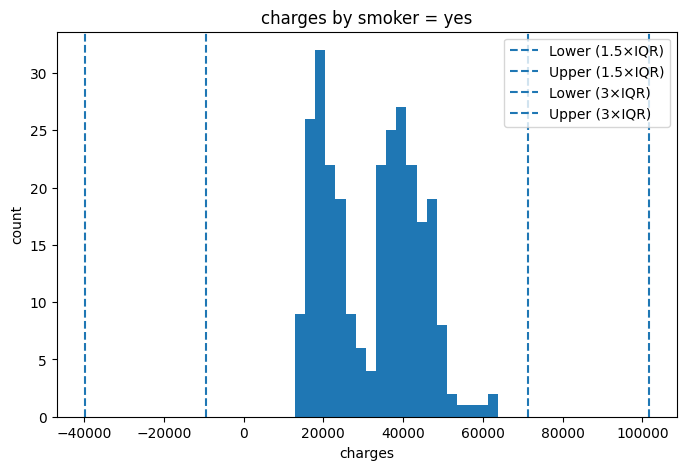

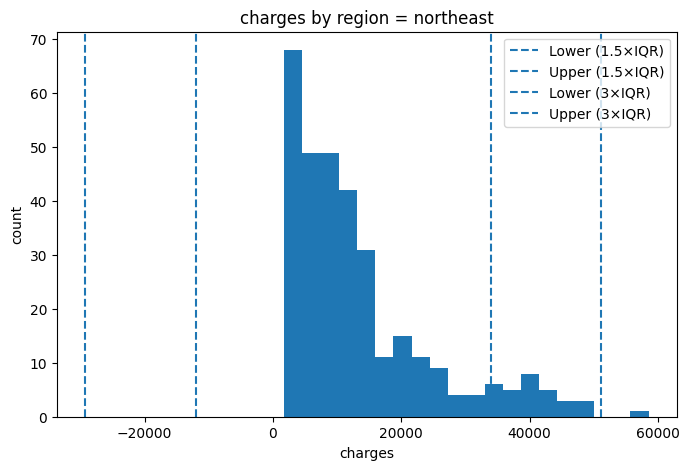

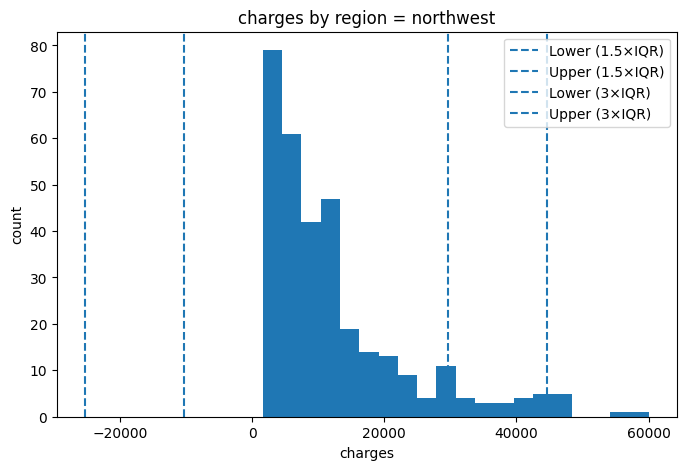

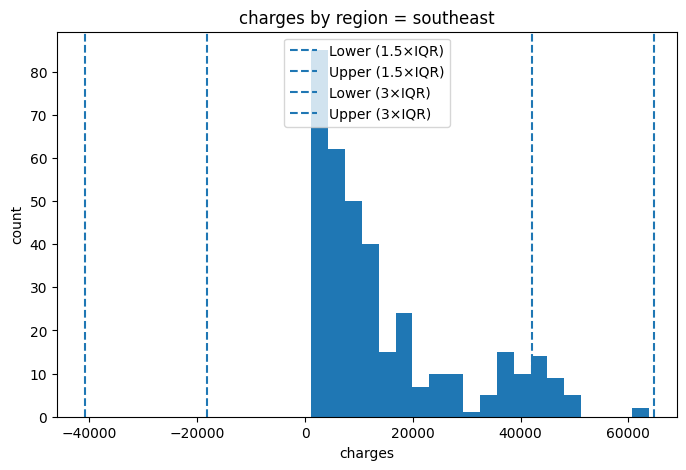

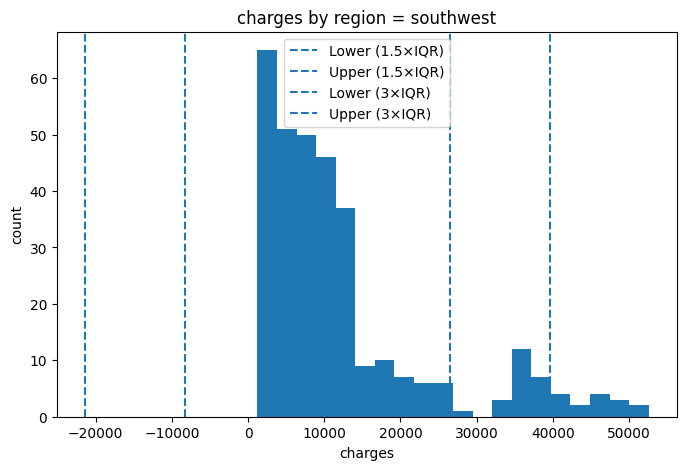

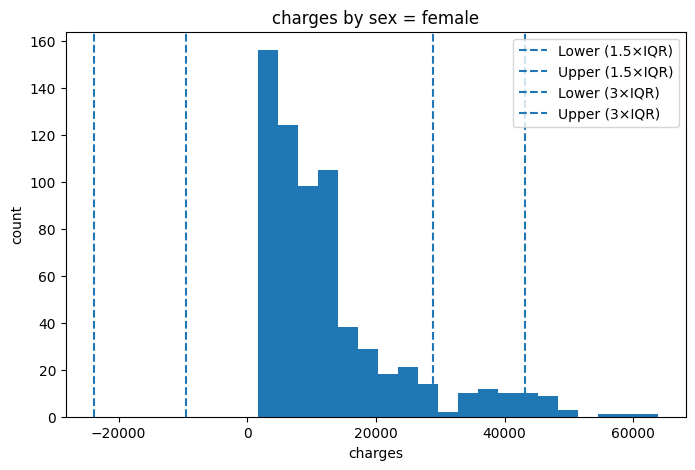

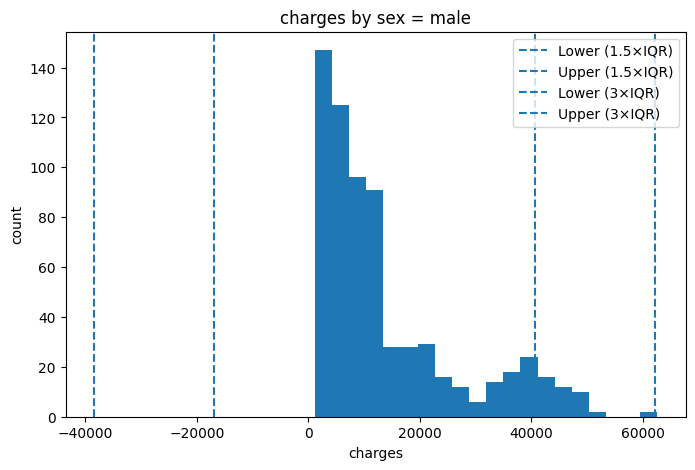

In [33]:
hist_per_group_with_bounds(df, feature="charges", by="smoker")
hist_per_group_with_bounds(df, feature="charges", by="region")
hist_per_group_with_bounds(df, feature="charges", by="sex")

### 4. Subgroup Analysis

Compare outliers across smoker, region, and sex groups.

In [41]:
print("Outliers in charges by smoker")
display(groupwise_iqr_flags(df, feature="charges", by="smoker"))
print()

print("Outliers in charges by region")
display(groupwise_iqr_flags(df, feature="charges", by="region"))
print()

print("Outliers in charges by sex")
display(groupwise_iqr_flags(df, feature="charges", by="sex"))

Outliers in charges by smoker


,smoker,n,q1,q3,lower_1p5,upper_1p5,lower_3p0,upper_3p0,mild_count,extreme_count,mild_pct,extreme_pct
0,no,1064,3986.438700,11362.887050,-7078.233825,22427.559575,-18142.906350,33492.232100,46,3,4.323308,0.281955
1,yes,274,20826.244213,41019.207275,-9463.200381,71308.651869,-39752.644975,101598.096462,0,0,0.000000,0.000000



Outliers in charges by region


,region,n,q1,q3,lower_1p5,upper_1p5,lower_3p0,upper_3p0,mild_count,extreme_count,mild_pct,extreme_pct
0,southwest,325,4751.070000,13462.5200,-8316.105000,26529.695000,-21383.28000,39596.870000,38,16,11.692308,4.923077
1,northeast,324,5194.322288,16687.3641,-12045.240431,33926.926819,-29284.80315,51166.489537,29,1,8.950617,0.308642
2,northwest,325,4719.736550,14711.7438,-10268.274325,29699.754675,-25256.28520,44687.765550,29,7,8.923077,2.153846
3,southeast,364,4440.886200,19526.2869,-18187.214850,42154.387950,-40815.31590,64782.489000,26,0,7.142857,0.000000



Outliers in charges by sex


,sex,n,q1,q3,lower_1p5,upper_1p5,lower_3p0,upper_3p0,mild_count,extreme_count,mild_pct,extreme_pct
0,female,662,4885.1587,14454.691825,-9469.140988,28808.991513,-23823.440675,43163.2912,65,22,9.818731,3.323263
1,male,676,4619.1340,18989.590250,-16936.550375,40545.274625,-38492.234750,62100.9590,44,1,6.508876,0.147929


### 5. Scatter & Trends

Scatterplots and trends show how BMI, age, and charges interact, with outliers highlighted.

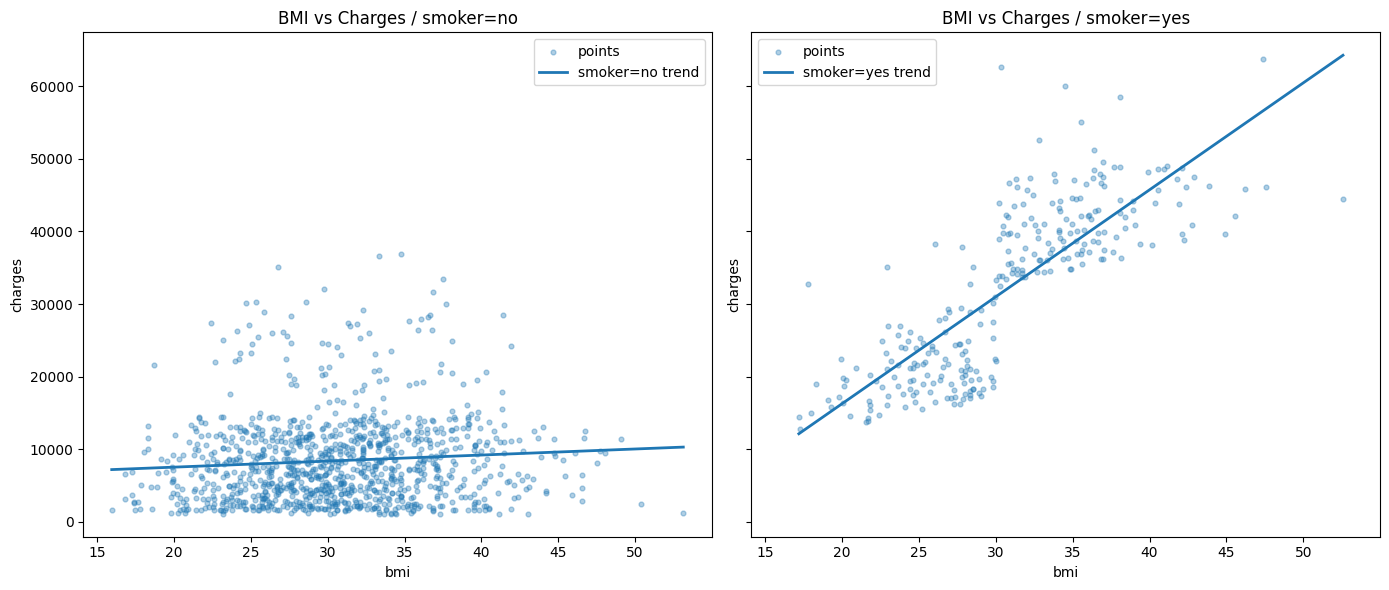

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)

for ax, grp in zip(axes, ["no", "yes"]):
    sub = df[df["smoker"] == grp]
    ax.scatter(sub["bmi"], sub["charges"], s=12, alpha=0.35, label="points")
    add_regression(ax, sub["bmi"].values, sub["charges"].values, f"smoker={grp}")
    ax.set_title(f"BMI vs Charges / smoker={grp}")
    ax.set_xlabel("bmi")
    ax.set_ylabel("charges")
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipython-input-7086116.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = y.groupby(cuts)


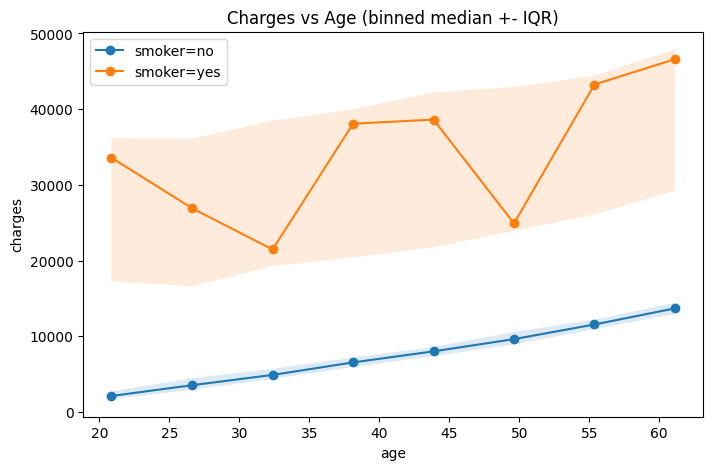

In [36]:
fig, ax = plt.subplots(figsize=(8,5))

for grp, sub in df.groupby("smoker"):
    med, q1, q3, cats = binned_stats(sub["age"], sub["charges"], bins=8)
    centers = [iv.left + (iv.right-iv.left)/2 for iv in cats]
    ax.plot(centers, med.values, marker="o", label=f"smoker={grp}")
    ax.fill_between(centers, q1.values, q3.values, alpha=0.15)

ax.set_title("Charges vs Age (binned median +- IQR)")
ax.set_xlabel("age")
ax.set_ylabel("charges")
ax.legend()
plt.show()

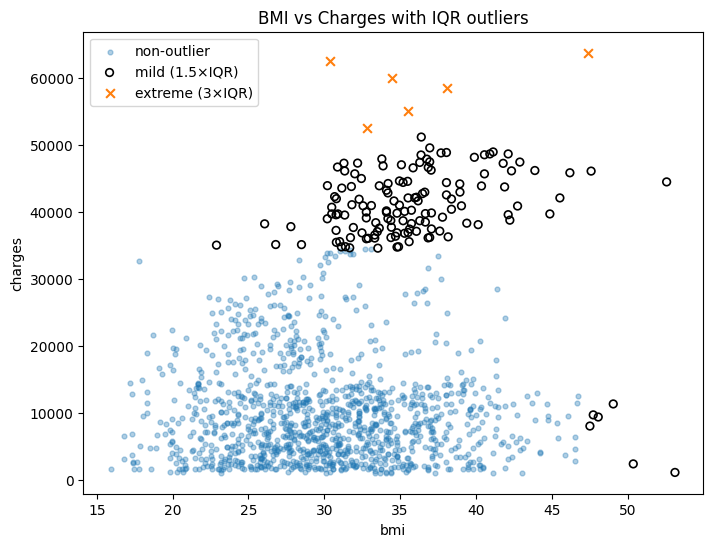

In [37]:
any_15 = flags_15.any(axis=1)
any_30 = flags_30.any(axis=1)

plt.figure(figsize=(8,6))
plt.scatter(df.loc[~any_15, "bmi"], df.loc[~any_15, "charges"], s=12, alpha=0.35, label="non-outlier")
plt.scatter(df.loc[any_15 & ~any_30, "bmi"], df.loc[any_15 & ~any_30, "charges"], s=30, facecolors="none", edgecolors="black", linewidths=1.2, label="mild (1.5×IQR)")
plt.scatter(df.loc[any_30, "bmi"], df.loc[any_30, "charges"], s=40, marker="x", linewidths=1.5, label="extreme (3×IQR)")

plt.title("BMI vs Charges with IQR outliers")
plt.xlabel("bmi")
plt.ylabel("charges")
plt.legend()
plt.show()

### 6. Distribution Views

Alternative views (violin, log-scale) show separation and skew more clearly.

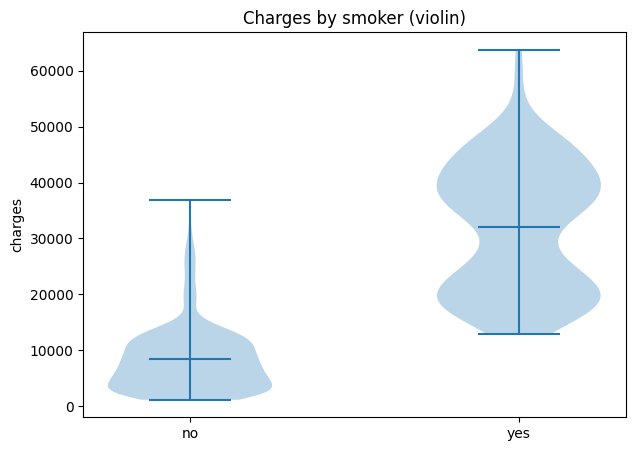

In [38]:
fig, ax = plt.subplots(figsize=(7,5))

data = [df[df["smoker"]=="no"]["charges"].values, df[df["smoker"]=="yes"]["charges"].values]

ax.violinplot(data, showmeans=True, showextrema=True)
ax.set_xticks([1,2])
ax.set_xticklabels(["no","yes"])
ax.set_title("Charges by smoker (violin)")
ax.set_ylabel("charges")
plt.show()

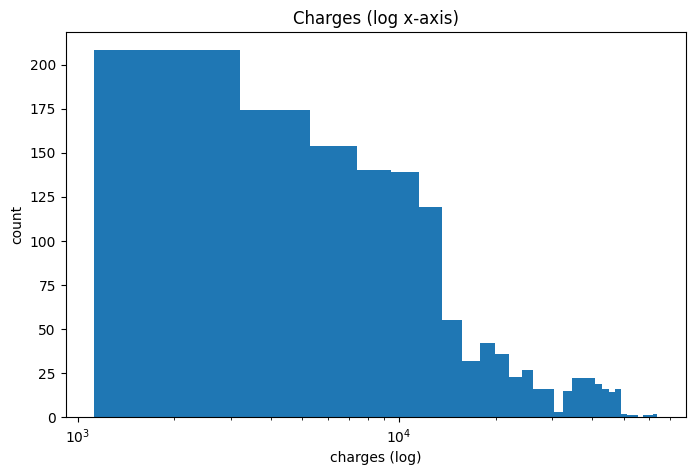

In [39]:
plt.figure(figsize=(8,5))
plt.hist(df["charges"], bins=30)
plt.yscale("linear")
plt.xscale("log")
plt.title("Charges (log x-axis)")
plt.xlabel("charges (log)")
plt.ylabel("count")
plt.show()

## Conclusion

**Age & Children**: Both features are clean, with no unusual outliers. Distributions are bounded and consistent.

**BMI**: A few high values (>47) appear, corresponding to severe obesity. These are realistic and meaningful cases, not errors.

**Charges**: Many high outliers are flagged, but these reflect real high-cost patients. The skewed distribution is expected in healthcare data.

**Subgroups**:

* Smokers show consistently higher charges, so their "outliers" are expected within that group.

* Regions behave similarly; no single region dominates in high costs.

* Sex differences are minor, with both groups sharing similar distributions.

**Trends**: Scatter and trend plots confirm that smoker status, higher BMI, and older age combine to drive extreme charges.


---


**Takeaway:**

The IQR method is useful for identifying unusual values, but interpretation requires context. In this dataset, the outliers are not mistakes. They highlight meaningful variation in healthcare costs, driven by lifestyle and demographic factors.